# Reproducing Gunseli CDA Study (2019) - Cleaning

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

from scipy.io import loadmat

from autoreject import AutoReject

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Gunseli-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['5'] = [5] 
triggers['6'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['5', '6']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

# Epoc Information
epoch_length = 1.2
epoch_tmin = -0.5
baseline_corr = (-0.2, 0)

# # CDA main variable & Reports
cda_dict = dict()
cda_dict_clean = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
#filepath = folderpath + 'raw data files/' + 'StratAtt_e2_LoadChans_pp11.set'

for filepath in glob.iglob(folderpath + 'raw data files/' + '*.set'):
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    raw = read_raw_eeglab(filepath, preload=True)

    # Resample
    preproc = raw.resample(500)

    # 2. -- General Preprocess --
    # Keep only EEG channels and reference
    #raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi64')
    #raw.set_montage(montage)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)

    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Use this for checksum & perf!
    #behavfilepath = folderpath + 'raw data files/' + 'subject-{}.csv'.format(filepath[filepath.rfind('pp')+2:filepath.rfind('.')])

    #behav = pd.read_csv(behavfilepath)  
    #behav_hl = behav['block_type'][(behav['block_type'] == 'low') | (behav['block_type'] == 'high')]

    # Redo Triggers based on annotation in file!
    new_triggers = copy.deepcopy(triggers)
    for k in new_triggers.keys():
        for i,t in enumerate(new_triggers[k]):
            if str(t) in events[1].keys():
                new_triggers[k][i] = events[1][str(t)]
    specific_events = get_specific_events(events[0], conds, sides, perfs, new_triggers)

    # Modify Events ID for cleaning stacking...
    for cond in conds:
        for side in sides:
            for perf in ['good']: #perfs:
                new_trigger = triggers[cond][0] + triggers[side][0]
                #print('{}-{}-{} new val: {}'.format(cond,side,perf, new_trigger))
                specific_events[cond][side][perf][:,2] = new_trigger

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # X. -- CLEANING! --
    # ------------------------
    ar = AutoReject()

    # Flatten epochs to clean all at once.
    epochs_dict_clean = dict()
    epochs_to_clean = []
    for c in epochs_dict.keys():
        epochs_dict_clean[c] = dict()
        for s in epochs_dict[c].keys():
            epochs_dict_clean[c][s] = dict()
            for p in ['good']:#epochs_dict[c][s].keys():
                epochs_dict_clean[c][s][p] = []
                epochs_to_clean.append(epochs_dict[c][s][p])

    len(epochs_to_clean)

    cleaned_epochs = ar.fit_transform(mne.concatenate_epochs(epochs_to_clean)) 

    # Reconstruct epochs                
    for cond in conds:
        for side in sides:
            for perf in ['good']: #perfs:
                new_trigger = triggers[cond][0] + triggers[side][0]
                epochs_dict_clean[cond][side][perf].append(cleaned_epochs[str(new_trigger)])

    # Concatenate Epochs into Epochs MNE structure (from a list of Epochs because of diff triggers)
    for cond in conds:
        for side in sides:
            for perf in ['good']: #perfs:
                epochs_dict_clean[cond][side][perf] = mne.concatenate_epochs(epochs_dict_clean[cond][side][perf])


    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict_clean)

    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)
    cda_dict_clean[filename] = get_CDA(epochs_dict_clean, conds, sides, ['good'], chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['5']['left']['good'].times

subreport = get_report(report, ['5','6'], ['left','right'], ['good'], [])
report

Processing: StratAtt_e2_LoadChans_pp2.set...
Reading /Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/raw data files/StratAtt_e2_LoadChans_pp2.fdt
Reading 0 ... 2452479  =      0.000 ...  4789.998 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 







Estimated consensus=1.00 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 91 events 







Estimated consensus=0.30 and n_interpolate=1



Dropped 44 epochs: 51, 55, 61, 71, 76, 79, 80, 90, 105, 116, 135, 145, 147, 163, 171, 192, 193, 235, 244, 249, 255, 263, 286, 288, 291, 292, 294, 316, 320, 333, 341, 370, 374, 381, 384, 430, 450, 453, 455, 459, 460, 462, 464, 497
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 bad epoc

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 490 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 65 events 







Estimated consensus=0.80 and n_interpolate=32



Dropped 15 epochs: 22, 34, 79, 81, 109, 113, 129, 163, 317, 349, 365, 403, 435, 449, 456
Not setting metadata
Not setting metadata
63 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (65 events vs 63 epochs)
Checksum FAILE

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 99 events 







Estimated consensus=0.60 and n_interpolate=1



Dropped 1 epoch: 300
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
63 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Invalid key for: 5-right-bad
Checksum FAILED! Invalid key for: 5-TBD-bad
Checksum FAILED! Lengt

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 







Estimated consensus=0.60 and n_interpolate=32



Dropped 5 epochs: 80, 83, 142, 301, 461
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (85 events vs 83 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! L

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events 







Estimated consensus=0.40 and n_interpolate=4



Dropped 17 epochs: 3, 30, 34, 68, 81, 109, 172, 214, 216, 234, 237, 241, 267, 326, 372, 404, 477
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
67 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (88 events vs 83 epochs)
Checks

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 







Estimated consensus=0.60 and n_interpolate=4



Dropped 14 epochs: 9, 18, 22, 90, 96, 99, 105, 134, 156, 375, 420, 429, 450, 492
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
66 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (85 events vs 82 epochs)
Checksum FAILED! Inval

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 474 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 69 events 







Estimated consensus=0.60 and n_interpolate=4



Dropped 2 epochs: 16, 384
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (69 events vs 68 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Invalid key for

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events 







Estimated consensus=0.60 and n_interpolate=4



Dropped 45 epochs: 2, 8, 11, 14, 15, 38, 39, 46, 48, 55, 88, 91, 96, 105, 110, 117, 125, 127, 129, 130, 132, 134, 154, 168, 178, 179, 180, 181, 182, 197, 203, 205, 207, 209, 210, 217, 235, 246, 299, 302, 305, 376, 387, 406, 483
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
66 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 79 events 







Estimated consensus=0.10 and n_interpolate=1



Dropped 182 epochs: 7, 8, 11, 12, 13, 21, 22, 23, 30, 31, 34, 36, 37, 40, 44, 52, 53, 55, 56, 60, 65, 68, 70, 73, 77, 78, 83, 91, 92, 99, 110, 112, 113, 114, 116, 118, 119, 120, 121, 122, 126, 128, 130, 131, 133, 134, 135, 138, 140, 147, 148, 149, 150, 153, 154, 159, 161, 165, 166, 170, 176, 178, 180, 188, 189, 196, 197, 199, 202, 206, 207, 208, 209, 215, 218, 220, 223, 226, 227, 228, 229, 230, 231, 232, 234, 236, 241, 242, 248, 251, 252, 254, 256, 257, 259, 262, 265, 268, 269, 274, 278, 281, 286, 292, 298, 302, 307, 309, 312, 314, 319, 321, 326, 329, 331, 333, 335, 336, 337, 338, 339, 344, 345, 346, 349, 352, 354, 355, 357, 359, 362, 369, 373, 376, 378, 379, 387, 389, 390, 392, 393, 397, 398, 399, 406, 408, 409, 410, 411, 415, 416, 417, 418, 419, 421, 422, 423, 426, 429, 434, 435, 438, 443, 450, 453, 459, 463, 464, 467, 472, 478, 479, 480, 481, 484, 486, 487, 489, 491, 495, 498, 499
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode:

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events 







Estimated consensus=0.90 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Data file name in EEG.data (StratAtt_e2_LoadChans_pp29set.fdt) is incorrect, the file name must have changed on disk, using the correct file name (StratAtt_e2_LoadChans_pp29.fdt).
  raw = read_raw_eeglab(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events 







Estimated consensus=0.30 and n_interpolate=4



Dropped 70 epochs: 10, 11, 14, 15, 23, 38, 44, 54, 57, 65, 70, 77, 84, 85, 88, 92, 130, 132, 142, 150, 162, 164, 165, 166, 188, 196, 203, 210, 212, 213, 215, 218, 229, 240, 241, 254, 257, 260, 262, 265, 268, 276, 280, 284, 294, 346, 347, 348, 350, 357, 360, 362, 363, 364, 366, 368, 371, 391, 396, 427, 429, 438, 442, 443, 444, 448, 452, 457, 461, 476
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
67 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropp

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 80 events 







Estimated consensus=0.60 and n_interpolate=4



Dropped 2 epochs: 24, 108
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (80 events vs 79 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Length mismatch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events 







Estimated consensus=0.40 and n_interpolate=4



Dropped 31 epochs: 25, 41, 52, 91, 132, 136, 159, 162, 178, 220, 223, 233, 286, 292, 296, 315, 324, 326, 342, 347, 362, 370, 373, 377, 380, 382, 385, 416, 443, 452, 478
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 92 events 







Estimated consensus=0.50 and n_interpolate=4



Dropped 17 epochs: 55, 74, 109, 146, 153, 227, 260, 271, 344, 370, 380, 412, 414, 420, 472, 482, 490
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (92 events vs 90 epochs)
Ch

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 69 events 







Estimated consensus=1.00 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events 







Estimated consensus=0.80 and n_interpolate=1



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 87 events 







Estimated consensus=0.50 and n_interpolate=4



Dropped 48 epochs: 16, 29, 52, 76, 77, 85, 112, 119, 136, 228, 247, 248, 257, 261, 269, 270, 274, 276, 280, 281, 288, 318, 324, 326, 339, 351, 374, 378, 385, 387, 388, 390, 397, 412, 425, 429, 437, 443, 447, 449, 461, 462, 466, 472, 475, 480, 495, 499
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events 







Estimated consensus=0.20 and n_interpolate=4



Dropped 154 epochs: 4, 14, 15, 16, 26, 30, 31, 33, 35, 40, 42, 43, 45, 49, 50, 56, 62, 63, 71, 74, 77, 79, 83, 84, 87, 88, 89, 91, 100, 107, 131, 132, 137, 139, 144, 147, 148, 160, 163, 170, 171, 172, 184, 185, 187, 188, 191, 205, 206, 207, 208, 213, 216, 217, 218, 222, 231, 232, 233, 242, 243, 245, 247, 248, 251, 252, 253, 254, 255, 257, 259, 260, 265, 267, 268, 269, 272, 273, 277, 278, 282, 292, 296, 302, 303, 306, 309, 314, 322, 323, 327, 328, 332, 333, 335, 336, 337, 338, 340, 342, 344, 348, 352, 357, 364, 367, 368, 372, 373, 377, 379, 381, 382, 387, 389, 390, 391, 393, 394, 401, 403, 405, 412, 419, 421, 422, 424, 425, 427, 428, 429, 430, 432, 435, 438, 439, 440, 441, 442, 459, 460, 464, 465, 471, 473, 476, 478, 480, 481, 489, 492, 495, 496, 498
Not setting metadata
Not setting metadata
61 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 events 







Estimated consensus=0.50 and n_interpolate=1



Dropped 7 epochs: 89, 161, 196, 211, 232, 281, 419
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
93 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Length mismatch for: 5-right-good (91 events vs 89 epochs)
Checks

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events 







Estimated consensus=0.60 and n_interpolate=1



Dropped 6 epochs: 12, 46, 92, 119, 120, 132
Not setting metadata
Not setting metadata
95 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (98 events vs 95 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILE

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events 







Estimated consensus=0.60 and n_interpolate=4



Dropped 4 epochs: 65, 72, 160, 208
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (83 events vs 81 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Length

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6', 'boundary']
Total: 489 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data fo







Estimated consensus=0.30 and n_interpolate=1



Dropped 37 epochs: 4, 32, 88, 117, 126, 139, 170, 171, 180, 194, 246, 253, 269, 274, 278, 285, 292, 297, 321, 334, 337, 340, 348, 349, 350, 362, 363, 364, 369, 419, 429, 430, 438, 440, 443, 456, 486
Not setting metadata
Not setting metadata
67 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '255', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 







Estimated consensus=0.10 and n_interpolate=4



Dropped 190 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 29, 30, 32, 41, 43, 46, 52, 61, 65, 66, 68, 69, 73, 74, 75, 80, 81, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 107, 108, 109, 110, 113, 114, 117, 119, 120, 121, 123, 124, 126, 130, 142, 143, 145, 148, 152, 156, 157, 159, 160, 164, 165, 174, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 199, 201, 202, 206, 207, 209, 212, 217, 218, 224, 233, 238, 243, 246, 258, 259, 260, 261, 262, 269, 274, 276, 280, 281, 284, 285, 287, 288, 290, 300, 301, 302, 303, 306, 307, 308, 319, 320, 326, 331, 332, 333, 336, 337, 338, 344, 345, 352, 353, 355, 357, 360, 363, 365, 366, 367, 368, 370, 371, 373, 376, 381, 382, 396, 397, 401, 407, 408, 413, 420, 423, 426, 429, 430, 432, 434, 437, 442, 448, 452, 453, 454, 455, 464, 468, 469, 474, 476, 483, 484, 490, 495, 498
Not setting metadata
Not setting metadata
44 matching events found
Applying baseline correct

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 74 events 







Estimated consensus=0.80 and n_interpolate=32



Dropped 4 epochs: 21, 345, 406, 444
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (74 events vs 73 epochs)
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Inval

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events 







Estimated consensus=0.80 and n_interpolate=4



Dropped 3 epochs: 107, 198, 396
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum FAILED! Length mismatch for: 5-right-good (87 events vs 86 epochs)
Checksum FAILED! Invalid 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 events 







Estimated consensus=0.90 and n_interpolate=4



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 90 events 







Estimated consensus=0.70 and n_interpolate=32



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Invalid key for: 5-left-bad
Checksum 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 







Estimated consensus=0.60 and n_interpolate=32



Dropped 15 epochs: 48, 53, 83, 137, 156, 238, 287, 294, 352, 369, 383, 384, 386, 387, 485
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (85 events vs 82 epochs)
Checksum FAIL

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_29649/3183442655.py:46: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:1.2, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events 







Estimated consensus=0.30 and n_interpolate=1



Dropped 30 epochs: 2, 10, 28, 38, 39, 43, 44, 55, 64, 72, 110, 115, 117, 139, 178, 184, 192, 209, 221, 229, 231, 237, 243, 310, 324, 345, 406, 431, 443, 480
Not setting metadata
Not setting metadata
66 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
63 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Verifying Checksum (events vs epochs)...
Checksum FAILED! Leng

,5,6,left,right,TBD,good,bad,5-left,5-left-good,5-good,...,6-left-bad,6-bad,6-right,6-right-good,6-right-bad,6-TBD,6-TBD-good,6-TBD-bad,checksum,notes
StratAtt_e2_LoadChans_pp2.set,250,250,160,159,181,500,0,85,85,250,...,0,0,81,81,0,94,94,0,0,
StratAtt_e2_LoadChans_pp3.set,250,250,168,171,161,500,0,91,91,250,...,0,0,95,95,0,78,78,0,0,
StratAtt_e2_LoadChans_pp4.set,240,250,150,171,169,490,0,65,65,240,...,0,0,89,89,0,76,76,0,0,
StratAtt_e2_LoadChans_pp5.set,250,250,188,140,172,500,0,99,99,250,...,0,0,77,77,0,84,84,0,0,
StratAtt_e2_LoadChans_pp7.set,250,250,167,186,147,500,0,85,85,250,...,0,0,97,97,0,71,71,0,0,
StratAtt_e2_LoadChans_pp6.set,250,250,171,163,166,500,0,88,88,250,...,0,0,73,73,0,94,94,0,0,
StratAtt_e2_LoadChans_pp13.set,250,250,158,163,179,500,0,85,85,250,...,0,0,91,91,0,86,86,0,0,
StratAtt_e2_LoadChans_pp12.set,224,250,147,143,184,474,0,69,69,224,...,0,0,73,73,0,99,99,0,0,
StratAtt_e2_LoadChans_pp10.set,250,250,173,161,166,500,0,88,88,250,...,0,0,82,82,0,83,83,0,0,
StratAtt_e2_LoadChans_pp11.set,250,250,167,151,182,500,0,79,79,250,...,0,0,65,65,0,97,97,0,0,


In [10]:
times = epochs_dict['5']['left']['good'].times

## 2. Save CDA Data

In [3]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_gunseli2019_raw.pkl","wb") as f:
    pickle.dump(cda_dict_clean, f)

## 3. Load CDA Data

In [4]:
with open("cda_gunseli2019_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

print("Participants: {}, Conditions: {}". format(len(cda_dict), cda_dict[list(cda_dict.keys())[0]].keys()))

KeyError: 'times'

## 4. Plot CDA Data - Grand CDA Average

Manual Skip...
Manual Skip...
Manual Skip...
Manual Skip...


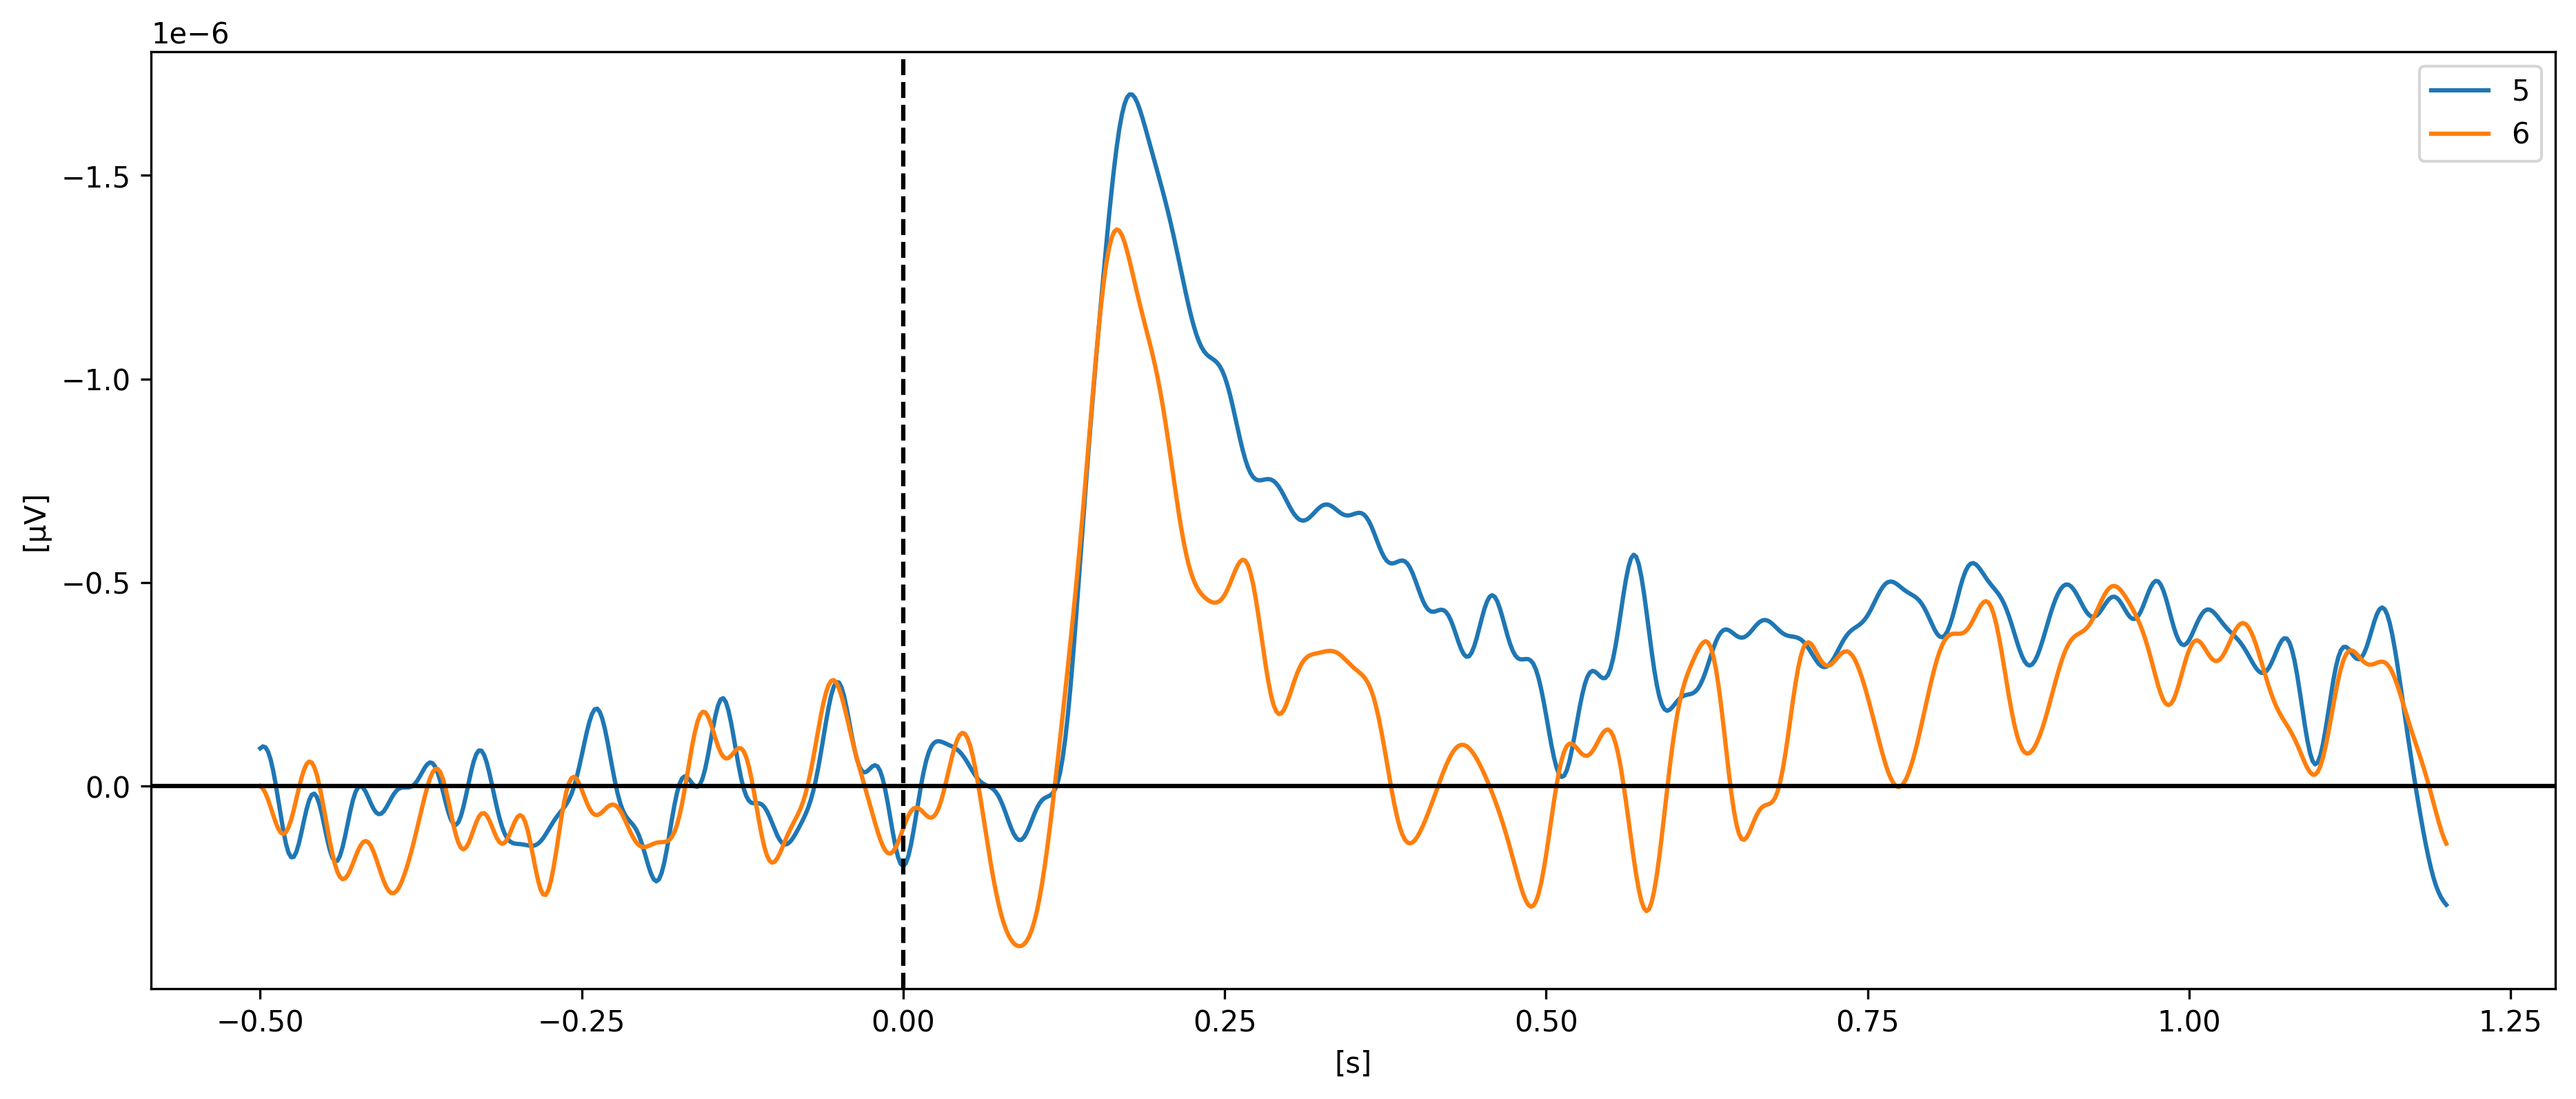

In [11]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
        
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all['5'].mean(0), label='5')
plt.plot(times, cda_all['6'].mean(0), label='6')

plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.savefig("Gunseli-2019_CDA-cleaning-raw.png", dpi=300, format='png')

Manual Skip...
Manual Skip...
Manual Skip...
Manual Skip...


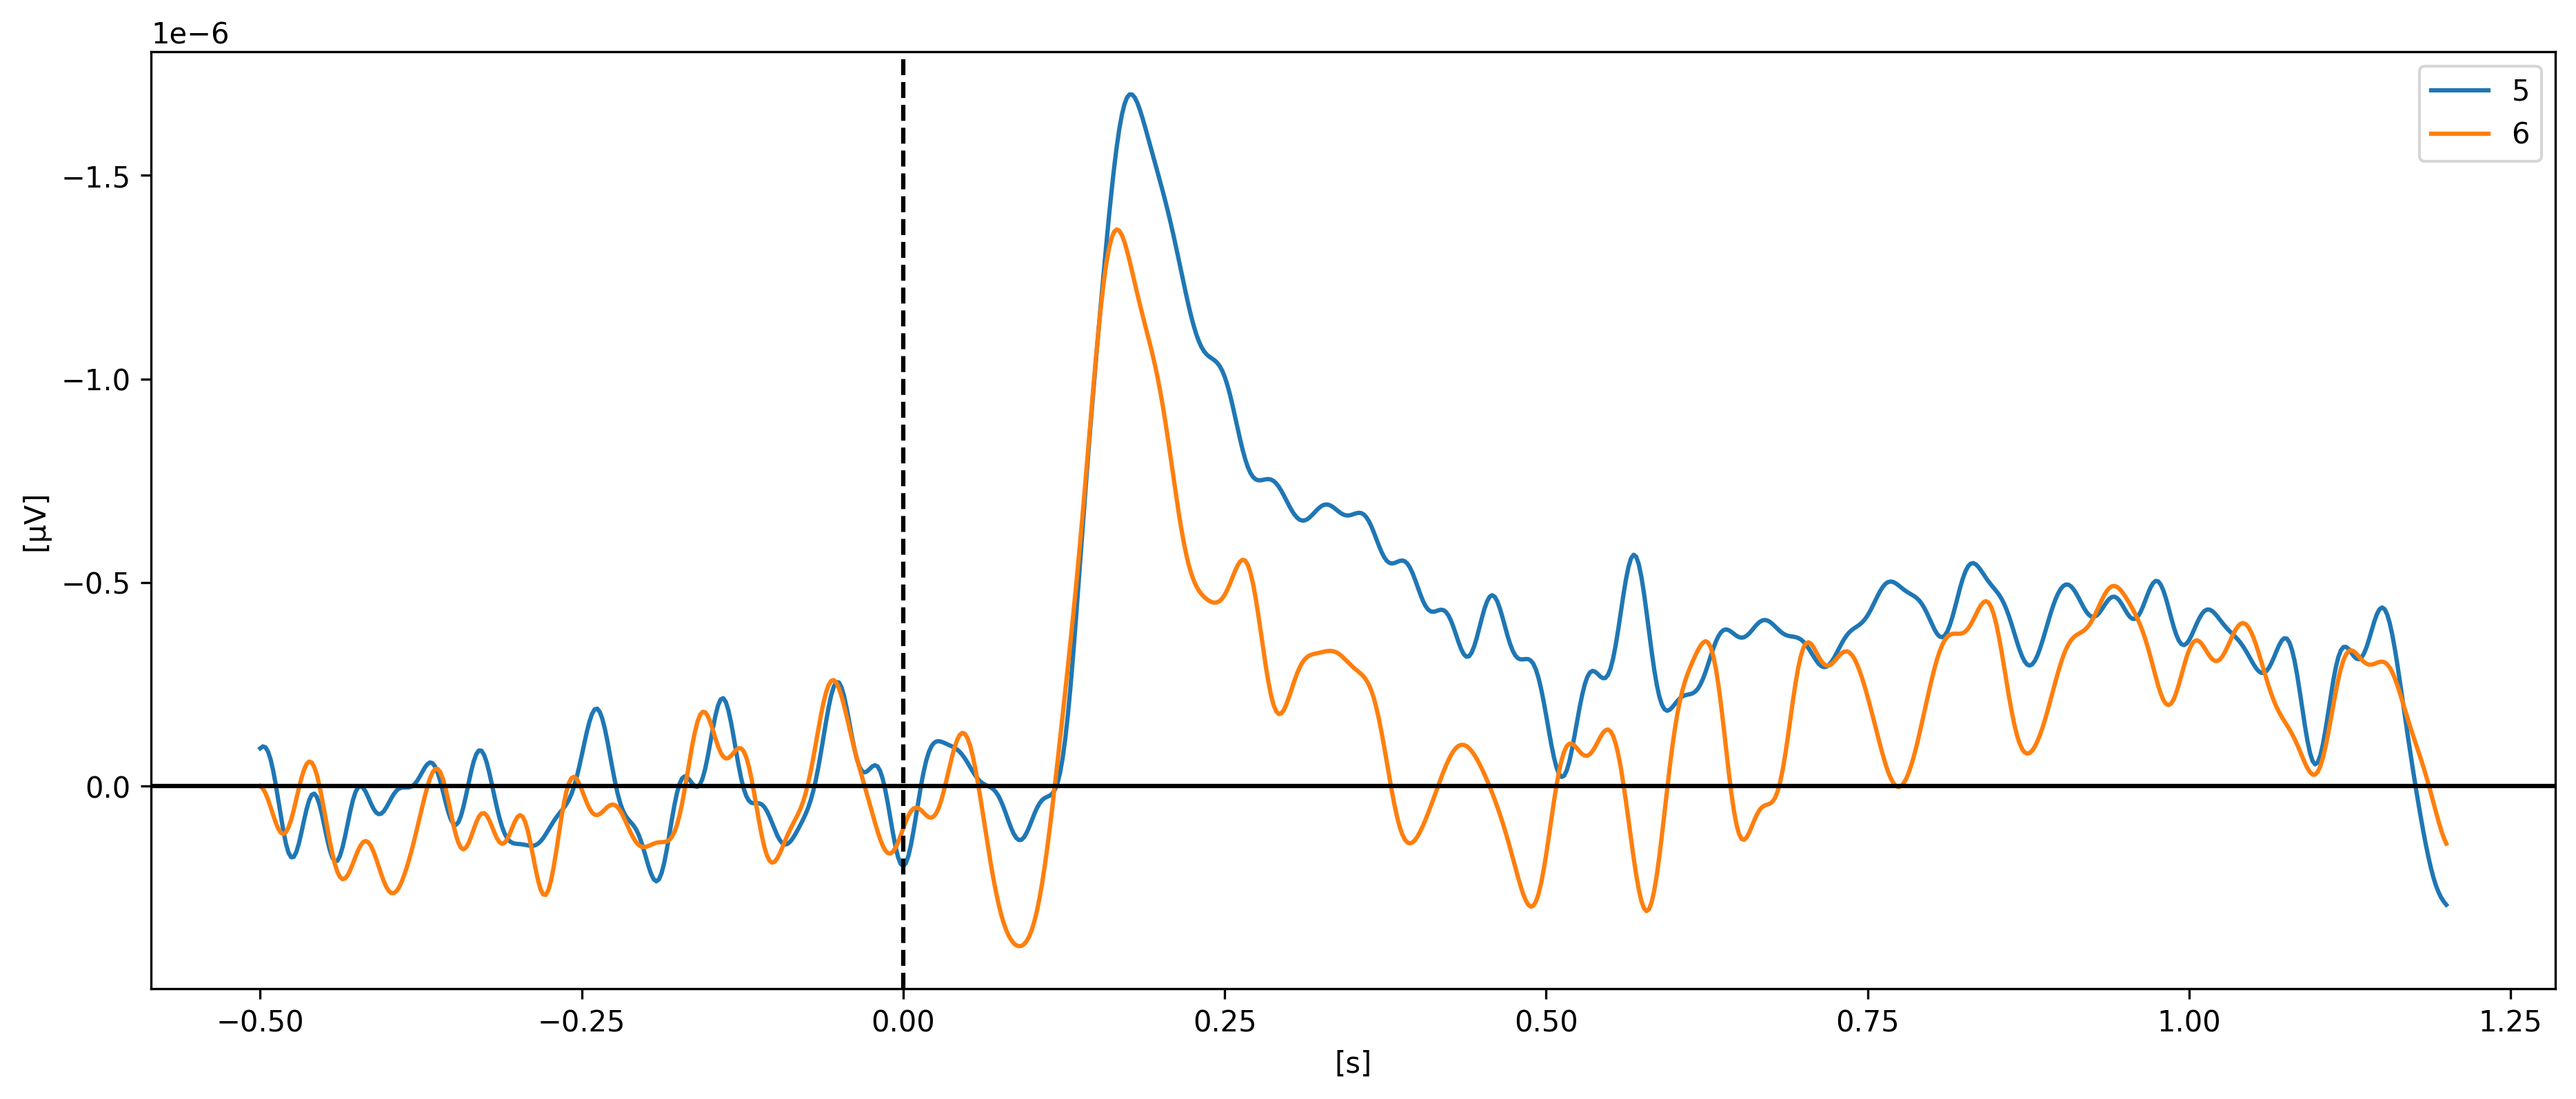

In [12]:
cda_all = dict()

for cond in cda_dict_clean[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
        
        perf = 'good'
        ldict = cda_dict_clean[f][cond]['left']
        rdict = cda_dict_clean[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict_clean[f][cond]['left'][perf] + cda_dict_clean[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
        
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all['5'].mean(0), label='5')
plt.plot(times, cda_all['6'].mean(0), label='6')

plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.savefig("Gunseli-2019_CDA-cleaning-clean.png", dpi=300, format='png')